In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [2]:
no_retract = pd.read_csv('./no_retraction_data_plos_only_cleaned.csv')
no_retract = no_retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

retract = pd.read_csv('./retraction_data_plos_only_cleaned.csv')
retract = retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [3]:
total = pd.read_csv('./total_data_plos_only_cleaned.csv')
total = total.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
total.head()

,doi,year,month,day,volume,issue,journal,title,text,abstract,keywords,retraction_binary,unpacked_keywords,clean_text,clean_text_lem
0,10.1208/s12249-016-0596-x,2016.0,8.0,10.0,18.0,5.0,AAPS PharmSciTech,Study of the Transformations of Micro/Nano-cry...,‘Polymorphism’ generally referred as the abili...,This study elucidates the physical properties ...,"['monoclinic', 'nano-sized crystals', 'orthorh...",1,"['monoclinic', 'nano-sized', 'crystals', 'orth...",Polymorphism generally referred as the ability...,Polymorphism generally referred a the ability ...
1,10.1021/acscentsci.9b00224,2019.0,5.0,9.0,5.0,6.0,ACS central science,Targeted Protein Internalization and Degradati...,Traditional\ndrug development efforts are focu...,Targeted,[],1,[],Traditional drug development efforts are focus...,Traditional drug development effort are focuse...
2,10.1021/acsomega.8b00488,2018.0,6.0,27.0,3.0,6.0,ACS omega,Regulating the Microstructure of Intumescent F...,Intumescent flame retardants\nare now being us...,A compatibilizer,[],1,[],Intumescent flame retardants are now being use...,Intumescent flame retardant are now being used...
3,10.1021/acsomega.8b00153,2018.0,6.0,25.0,3.0,6.0,ACS omega,Solid-to-Solid Crystallization of Organic Thin...,Crystal growth process is basic and essential ...,The solid-to-solid crystallization processes o...,[],1,[],Crystal growth process is basic and essential ...,Crystal growth process is basic and essential ...
4,10.1107/S1600536811022574,2011.0,6.0,18.0,67.0,NaN,"Acta crystallographica. Section E, Structure r...",Oxonium picrate.,For general background to organic salts of pic...,"The title compound, H3O+·C6H2N3O7",[],1,[],For general background to organic salts of pic...,For general background to organic salt of picr...


In [4]:
lemmatizer = WordNetLemmatizer()
lem_stopwords = [lemmatizer.lemmatize(i) for i in stopwords.words("english")]

retraction_stopwords = ['wa', 'using', 'et', 'al', 'figure', 'usepackage', 'used', 'fig', 'also', 
                        'ml', 'ha', 'two', 'one', 'may', 'based', 'table', 'however', 'data', 'mm', 'ms']

science_stopwords = ['any','apply','applying','reapplying','given','papers','paper','about',
                     'results','result','real','world','page','article','present','takes',
                     'account', 'previous','work','propose','proposes','proposed','simply','simple',
                     'demonstrate','demonstrated','demonstrates','realworld','datasets','dataset',
                     'provide','important','research','researchers','experiments','experiment','unexpected',
                     'discovering','using','recent','collected','solve','columns','existing','traditional',
                     'final','consider','presented','provides','automatically','extracting','including','help',
                     'helps','explore','illustrate','achieve','better']

In [69]:
X = total['clean_text_lem']
y = total['retraction_binary']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [8]:
y_test.value_counts(normalize=True).mul(100).round(2)

0    85.7
1    14.3
Name: retraction_binary, dtype: float64

In [71]:
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = stopwords.words("english")+ lem_stopwords + retraction_stopwords + science_stopwords, #stopwords were removed
                            max_features = 20000)

vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())

In [57]:
tvec = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, 
                       stop_words = stopwords.words("english")+ lem_stopwords + retraction_stopwords + science_stopwords)

X_train_df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
X_test_df = pd.DataFrame(tvec.transform(X_test).toarray(),
                  columns=tvec.get_feature_names())

In [72]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_df, y_train)

DecisionTreeClassifier()

In [76]:
count = 0
for i in dtc.feature_importances_:
    if i != 0:
        count += 1
print(count)

275


In [38]:
print(f'Score on training set: {dtc.score(X_train_df, y_train)}')
print(f'Score on testing set: {dtc.score(X_test_df, y_test)}')

Score on training set: 0.9142287234042553
Score on testing set: 0.8994725411107664


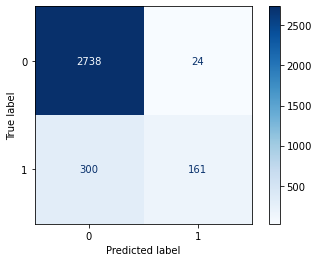

In [39]:
plot_confusion_matrix(dtc, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
#No limit for depth

#20000 features, more stopwords, 100% train, 91.8% test, 268 true positive, 116 false negative, 104 false positive
#5000 features, more stopwords/bigrams, ~100% train, 90.0% test, 251 true positive, 133 false negative, 139 false positive

In [ ]:
#All max depth = 5

# 20000 features, more stopwords, 93.5% train, 91.8% test, 217 true positive, 167 false negative, 52 false positive
# 20000 features, more stopwords/test size = 0.3, 93.5% train, 91.9% test, 261 true positive, 200 false negative, 60 false positive

# 5000 features, more stopwords/bi-grams, 91.4% train, 90.0% test, 141 true positive, 243 false negative, 25 false positive
# 5000 features, more stopwords/bi-grams/test size = 0.3, 91.4% train, 89.9% test, 161 true positive, 300 false negative, 24 false positive

In [48]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        bootstrap = True,
                        random_state=42)

bag.fit(X_train_df, y_train)
print(bag.score(X_train_df, y_train))
bag.score(X_test_df, y_test)

0.9937942162095073


0.9251675353685778

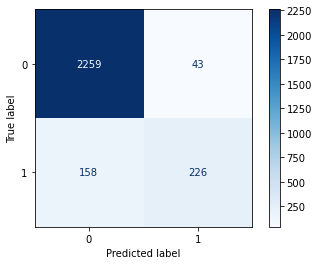

In [49]:
plot_confusion_matrix(bag, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
# 20000 features, more stopwords, 99.3% train, 93.9% test, 253 true positive, 131 false negative, 34 false positive
# 5000 features, more stopwords/bi-grams, 99.4% train, 92.5% test, 226 true positive, 158 false negative, 43 false positive

In [58]:
rfc = RandomForestClassifier (random_state = 42)

rfc.fit(X_train_df, y_train)
print(rfc.score(X_train_df, y_train))
rfc.score(X_test_df, y_test)

0.9998758843241902


0.913626209977662

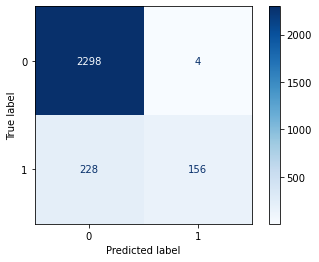

In [59]:
plot_confusion_matrix(rfc, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
# 20000 features, more stopwords, 100% train, 90.1% test, 117 true positive, 267 false negative, 0 false positive
# 5000 features, more stopwords/bigrams, ~100% train, 91.4% test, 156 true positive, 228 false negative, 4 false positive

In [67]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        bootstrap = True,
                        random_state=42)

ada = AdaBoostClassifier(base_estimator=base_tree,
                         random_state=42)

ada.fit(X_train_df, y_train)
print(ada.score(X_train_df, y_train))
ada.score(X_test_df, y_test)

1.0


0.9151154132539091

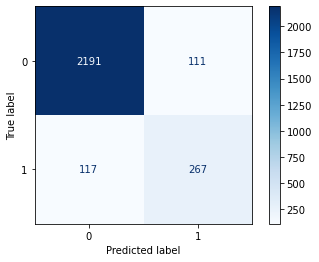

In [68]:
plot_confusion_matrix(ada, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
# 20000 features, more stopwords/boost a tree, 100% train, 91.5% test, 267 true positive, 117 false negative, 111 false positive
#boosting a bag changed nothing

In [5]:
X = total['clean_text_lem']
y = total['retraction_binary']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = stopwords.words("english")+ lem_stopwords + retraction_stopwords + science_stopwords, #stopwords were removed
                            max_features = 20000)

vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())


In [10]:
dtc_params = {
#               'splitter' : ['best', 'random'],
              'max_depth' : [10, 100, 1000, 10000],
#               'min_samples_split' : [2, 10, 100, 1000],
#               'class_weight' : [None, "balanced"],
#               'ccp_alpha' : [0, 0.1, 0.5, 1],
#               'min_impurity_decrease' : [0, 0.1, 0.25, 0.5]
}

dtc_grid = GridSearchCV(DecisionTreeClassifier(),
                       dtc_params,
                       cv = 5,
                       verbose = 1)

In [11]:
dtc_grid.fit(X_train_df, y_train)
print(dtc_grid.best_score_)
print(dtc_grid.score(X_test_df, y_test))
print(dtc_grid.best_params_)
pd.DataFrame(dtc_grid.cv_results_).sort_values('rank_test_score').head()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
#splitter: best 